In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from typing import Union, List

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *



In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
listings_raw = pd.read_csv("../data/raw/munich/2020-05-24/listings.csv.gz",compression="gzip")
listings_raw.shape

(11128, 106)

In [170]:
listings = listings_raw.copy()

In [171]:
# Mietspiegel Preise 2020 : https://www.wohnungsboerse.net/mietspiegel-Muenchen/2091
#del listings


In [172]:
def text_contains_word(df: pd.DataFrame, search_features: Union[str, List[str]], word: Union[str,List[str]], feature_name: str) -> pd.DataFrame:
    """
    Checks if at least one of the given features contains a given word.

    Input:
    - df: pd.DataFrame
    - search_features: names of columns with text data
    - word: str or list of words to search in the features
    - feature_name: name of new feature

    Returns:
    - pd.DataFrame with a new column named after the given words and representing a true/false flag.
    """
    if isinstance(word, list):
        word = [w.lower() for w in word]
        search_term = "|".join(word) # pipe for "or"-search
    else:
        search_term = word.lower()

    df[search_features] = df[search_features].apply(lambda x: x.str.lower())
    df[feature_name] = df[search_features].apply(lambda x: any(x.str.contains(search_term) & x.notna()), axis=1)
    return df

In [173]:
def mean_price(df: pd.DataFrame, feature):
    """Get mean price grouped by the given feature."""
    return df.groupby(feature).price.mean(),df.groupby(feature).price.median(), df[feature].value_counts()

In [174]:
def format_flags(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Format t / f to boolean True and False
    """
    flags = {"t": True, "f": False, "nan": np.NaN}
    for col in columns:
        df[col] = df[col].replace(flags)
        df[col] = df[col].astype(bool)
    return df

In [175]:
def make_dummies(series: pd.Series, name: str, sep="|") -> pd.DataFrame:
    """
    Performs one-hot encoding and renames the resulting columns by prepending the name parameter to column names
    """
    dummies = series.str.get_dummies(sep=sep)
    dummies.columns = name + dummies.columns
    for col in dummies.columns:
        dummies[col] = dummies[col].astype(bool)
    return dummies

In [176]:
# Make description-based feature
words = ["roof top", "roof-top", "Dachterasse","Dachterrasse","roof terrace"]
descriptive_columns = ["space", "description"]
listings = text_contains_word(listings, descriptive_columns, words, "roof_top_terrace")

In [177]:
# Format price
listings["price"] = format_price(listings["price"])

In [178]:
# Perform one-hot encoding for amenities
amenities = listings_raw.amenities.str.replace("[{""}]", "")\
                    .str.replace("\"", "")
amenities = make_dummies(amenities, name="amenities_",sep=",")
amenities["total_amount_amenities"] = amenities.sum(axis=1)

# Add (one-hot encoded) amenity features to dataset
listings = pd.concat([listings, amenities], axis=1)


(11128, 257)

In [179]:
# Convert host_since to number of month the host is active on AirBnB
listings["host_since_month"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["host_since"])).astype('timedelta64[M]')

In [180]:
listings = text_contains_word(listings, ["host_location"], ["Munich", "München"], "host_in_munich")


In [181]:
response_time_encoding = {"within an hour": 1,
                          "within a few hours": 2,
                          "within a day": 3,
                          "a few days or more": 4,
                          "nan": np.NaN}
listings.host_response_time.replace(response_time_encoding, inplace=True)

In [182]:
# remove %-sign from features containing rates
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%","").astype(float)
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].str.replace("%","").astype(float)



In [183]:
listings["host_in_different_neighbourhood"] = listings["host_neighbourhood"] != listings["neighbourhood"]

In [184]:
neighbourhood_other = listings["host_neighbourhood"].value_counts()[listings["host_neighbourhood"].value_counts()<=20].index
host_neighbourhood = make_dummies(listings["host_neighbourhood"].replace(neighbourhood_other, "other"), name="host_neighbourhood_", sep=" - ")

neighbourhood = make_dummies(listings["neighbourhood"], name="neighbourhood_" , sep=" - ")

listings = pd.concat([listings, host_neighbourhood], axis=1)
listings = pd.concat([listings, neighbourhood], axis=1)

In [185]:
# Get flag columns and reformat 
flag_cols = listings.apply(lambda x: 'f' in x.dropna().unique() or 't' in x.dropna().unique()).loc[lambda x: x==True].index.values
listings = format_flags(listings, flag_cols)

In [186]:
# encode host verification
listings["host_verifications"] = listings["host_verifications"].str.replace("\[|\]|'| ","")#.str.get_dummies(sep=",", drop_first=True)#.sum().sort_values()
host_verification_encoding = make_dummies(listings["host_verifications"], name="", sep=",")
# build a group of encoded host verification with just a few samples
other = host_verification_encoding.sum().loc[lambda x: x<100].index.values
host_verification_encoding["other"] = host_verification_encoding[other].any(axis=1)
host_verification_encoding.drop(columns=other, inplace=True)
host_verification_encoding.columns = "host_verification_" + host_verification_encoding.columns#

listings = pd.concat([listings, host_verification_encoding], axis=1)

In [187]:
# Create "category" for categories that occur seldom. Only make an exception for "villa" since the average price niveau for a "villa" is significantly higher.
other_property_types = listings.loc[listings["property_type"]!="Villa","property_type"].value_counts().loc[lambda x: x < 20].index.values
listings["property_type"] = listings["property_type"].apply(lambda x: "other" if any([p_type in x for p_type in other_property_types]) else x)
property_encoding = make_dummies(listings["property_type"], name="property_type_")
listings = pd.concat([listings, property_encoding], axis=1)


In [188]:
# use zipcode directly as discrete variable since the codes provide information about how far away one zipcode is from another
listings["zipcode"] = listings["zipcode"].str[:5] # make sure that the zipcode contains 5 digits
listings["zipcode"] = listings["zipcode"].astype(float)

In [189]:
#listings.room_type.value_counts(normalize=True)
room_type = make_dummies(listings["room_type"], name="room_type_")
listings = pd.concat([listings, room_type], axis=1)

In [190]:
#listings.bed_type.value_counts(normalize=True)
bed_type = make_dummies(listings["bed_type"], name="bed_type_")
listings = pd.concat([listings, bed_type], axis=1)

In [191]:
#listings.cancellation_policy.value_counts(normalize=True)
cancellation_policy = make_dummies(listings["cancellation_policy"], name="cancellation_policy_")
listings = pd.concat([listings, cancellation_policy], axis=1)

In [192]:
drop_cols = ['listing_url',
            'scrape_id',
            'last_scraped',
            'thumbnail_url', 
            'medium_url',
            'picture_url', 
            'xl_picture_url',
            'host_thumbnail_url', 
            'host_picture_url',
            'calendar_last_scraped',
            'name',
            'summary',
            'scrape_id',
            'country_code',
            'country',
            'amenities',
            'space',
            'description',
            'id',
            'neighborhood_overview',
            'notes',
            'transit',
            'experiences_offered',
            'host_since',
            'access', 
            'interaction',
            'house_rules',
            'host_id',
            'host_url',
            'host_name',
            'host_location',
            'host_about',
            'host_neighbourhood',
            'neighbourhood',
            'host_verifications',
            'street',
            'zipcode',
            'city',
            'market', 
            'smart_location',
            'property_type',
            'state',
            'weekly_price',
            'monthly_price',
            'security_deposit',
            'cleaning_fee',
            'extra_people',
            'calendar_updated',
            'first_review',
            'last_review',
            'bed_type',
            'room_type',
            'cancellation_policy',
            'neighbourhood_cleansed',
            'license',
            ]
listings.drop(columns=drop_cols, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000217D4D8E250>,
      dtype=object)

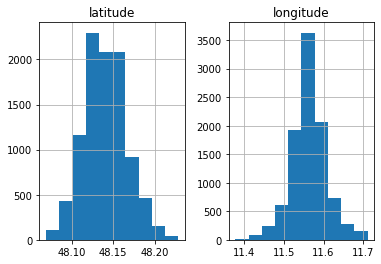

In [239]:
listings[["latitude","longitude"]]

In [253]:
clustering.cluster_centers_

array([[-0.03488385,  0.02440659]])

In [274]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    See:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-pointshttps://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_to_point_of_interest(df):
    points_of_interest = {"oktoberfest_geo_location": (48.130910, 11.548901),
    "munich_main_station_geo_location": (48.140283, 11.560488),
    "munich_hofbraeuhaus_geo_location": (48.137612, 11.579911),
    "munich_englischer_garten_geo_location": ( 48.152066, 11.592246 ),
    "munich_deutsches_museum_geo_location": ( 48.129929, 11.583482 )}

    for poi, coords in points_of_interest.items():
        df[poi] = df.apply(lambda x: haversine(x["longitude"], x["latitude"], coords[1], coords[0]), axis=1)

    return df

In [275]:
listings = distance_to_point_of_interest(listings)

In [287]:
listings["average_poi_distance"] = listings.apply(lambda x: x[x.index.str.contains("geo_location")].mean(),axis=1)

In [336]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(listings[["latitude","longitude"]], (lambda u,v: haversine(u[1], u[0],v[1],v[0]))))

db = DBSCAN(eps=0.2, min_samples=10, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
result = db.fit_predict(distance_matrix)


In [337]:
np.unique(result)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [338]:
listings["geo_cluster"] = result

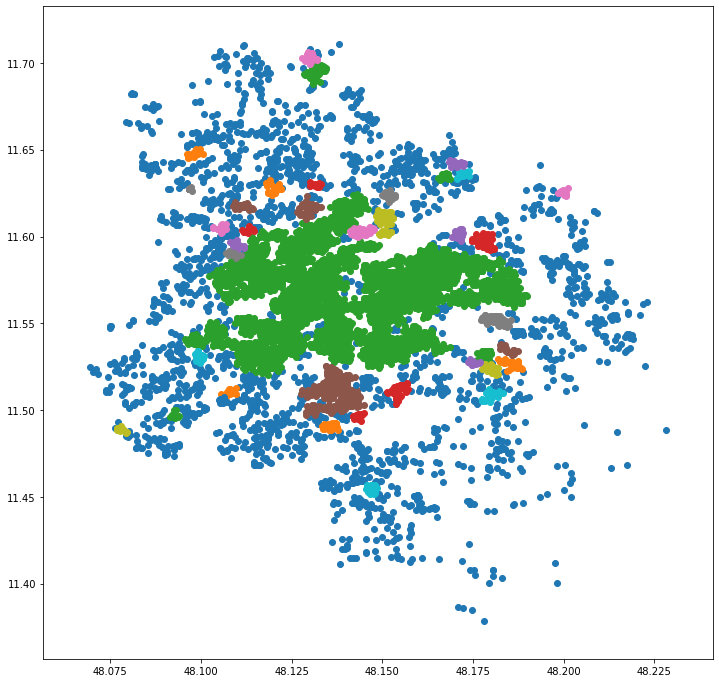

In [339]:
plt.figure(figsize=(12,12))
for cl in listings.geo_cluster.unique():
    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"])
plt.show()

In [193]:
# Drop columns with >50% NaNs
listings.drop(columns=(listings.isna().sum() / len(listings)).loc[lambda x: x>0.5].index.values, inplace=True)

In [195]:
listings_copy = listings.copy()

In [232]:
listings = listings_copy.copy()

In [229]:
listings.drop(columns=["latitude","longitude"], inplace=True)

In [233]:
# Drop outliers
listings = listings[listings["price"] < listings["price"].quantile(0.9)]
listings = listings[listings["price"] > listings["price"].quantile(0.01)]

In [234]:
# Remove features with only one observed value
listings.drop(columns=listings.apply(lambda x: x.nunique() <= 1).loc[lambda x: x==True].index.values, inplace=True)

array([0], dtype=int64)

In [288]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

listings = shuffle(listings)
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns=["price"]), listings["price"], test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(listings[["longitude","latitude","host_is_superhost",'roof_top_terrace','accommodates','bathrooms','bedrooms', 'beds']], listings["price"], test_size=0.33, random_state=42)

In [289]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

# Create a imputer to replace missing values of numerical features with mean
numeric_features = listings.drop(columns=["price"]).select_dtypes(np.number).columns

#imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = KNNImputer(n_neighbors=10, weights="uniform")
imp = imp.fit(X_train[numeric_features])

X_train[numeric_features] = imp.transform(X_train[numeric_features])
X_test[numeric_features] = imp.transform(X_test[numeric_features])

reg = LinearRegression().fit(X_train, y_train)
score_reg = reg.score(X_test, y_test)
print(score_reg)

reg = RandomForestRegressor().fit(X_train, y_train)
score_reg = reg.score(X_test, y_test)
print(score_reg)


0.22710860698735302
0.30340250373314126


In [237]:
listings.corr().loc[listings.corr().loc["price",:].abs()>0.01]

,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
host_acceptance_rate,1.000000,0.221571,0.018959,0.018959,0.023072,-0.073455,0.004877,0.047677,0.090318,0.020670,...,-0.022524,0.006759,-0.014786,0.024350,-0.051872,0.030344,NaN,0.021429,0.015171,0.005814
host_is_superhost,0.221571,1.000000,0.010694,0.010694,0.022906,0.068326,-0.044493,0.051425,0.071618,0.001540,...,0.004403,-0.017446,0.014579,-0.003466,-0.131178,0.041735,-0.004013,0.100151,0.036224,-0.005676
host_has_profile_pic,0.023072,0.022906,0.006609,0.006609,1.000000,0.040059,0.005729,-0.011653,0.010190,0.005878,...,0.005653,0.005149,0.002638,-0.007026,-0.024505,0.013717,0.000699,0.012688,0.000988,0.000988
host_identity_verified,-0.073455,0.068326,-0.017249,-0.017249,0.040059,1.000000,-0.021192,-0.003551,-0.004554,-0.009232,...,0.015390,0.006262,0.031617,-0.035665,-0.078106,0.022982,-0.006843,0.061871,0.021245,-0.009678
latitude,0.004877,-0.044493,-0.000043,-0.000043,0.005729,-0.021192,1.000000,-0.069383,-0.032516,-0.031410,...,-0.021892,0.004869,-0.025081,0.024183,0.034321,-0.010038,-0.001996,-0.027514,-0.004880,0.011589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bed_type_Pull-out Sofa,-0.014786,0.014579,-0.010019,-0.010019,0.002638,0.031617,-0.025081,0.013683,-0.003062,-0.060841,...,-0.013935,-0.012694,1.000000,-0.809036,-0.001854,0.004764,-0.001723,-0.002683,-0.002436,-0.002436
bed_type_Real Bed,0.024350,-0.003466,0.012746,0.012746,-0.007026,-0.035665,0.024183,-0.007584,0.023129,0.076782,...,-0.390498,-0.355723,-0.809036,1.000000,0.004482,-0.004248,0.002129,-0.000782,0.003012,0.003012
cancellation_policy_flexible,-0.051872,-0.131178,-0.022300,-0.022300,-0.024505,-0.078106,0.034321,-0.045509,-0.006839,-0.122941,...,0.003133,-0.009124,-0.001854,0.004482,1.000000,-0.560220,-0.008486,-0.519554,-0.012002,-0.012002
cancellation_policy_moderate,0.030344,0.041735,-0.023207,-0.023207,0.013717,0.022982,-0.010038,0.011921,0.017018,0.016002,...,-0.008489,0.003871,0.004764,-0.004248,-0.560220,1.000000,-0.006786,-0.415464,-0.009597,-0.009597


False